In [1]:
import numpy as np
import sympy as sp

import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{amsmath}',
    'text.usetex': True,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica']
})

# finite difference solver

In [ ]:
def get_U_fde(dt,x,V=lambda t: np.full(t.shape[0],0),m=1):
    dx = x[1] - x[0]
    N  = x.shape[0]
    H  = -(np.diag(np.full(N-1,1),k=-1) - np.diag(np.full(N,2),k=0) + np.diag(np.full(N-1,1),k=1))/2/m/dx**2 + np.diag(V(x),k=0)
    H[0][:2]   = np.array([1,0])
    H[-1][-2:] = np.array([0,1])
    print(H)
    
    U = np.eye(N) - complex(0,dt)*H
    return U

def get_U_fdi(dt,x,V=lambda t: np.full(t.shape[0],0),m=1):
    dx = x[1] - x[0]
    N  = x.shape[0]
    H  = -(np.diag(np.full(N-1,1),k=-1) - np.diag(np.full(N,2),k=0) + np.diag(np.full(N-1,1),k=1))/2/m/dx**2 + np.diag(V(x),k=0)
    H[0][:2]   = np.array([1,0])
    H[-1][-2:] = np.array([0,1])
    
    U = np.eye(N) + complex(0,dt)*H
    return U

In [ ]:
def gauss_psi(x,t,a=1,m=1):
    gam = complex(1,2*a*t/m)
    return (2*a/np.pi)**(1/4)*1/np.sqrt(gam)*np.exp(-a*x**2/gam)

test explicit evolution

In [ ]:
x  = np.linspace(-10,10,50)
dx = x[1] - x[0]

x0,sig = 0,1
psi0    = (2*np.pi*sig**2)**(-1/4)*np.exp(-(x-x0)**2/4/sig**2)

dt = 0.001
print(dt/dx**2)
U  = get_U_fde(dt,x)
np.abs(np.linalg.eigvals(U))

In [ ]:
# for _ in rho[0]:
rho0 = np.abs(psi0)**2
plt.plot(x,rho0,'k.')
temp = gauss_psi(x,0,a=1/4/sig**2)
plt.plot(x,np.real(temp*temp.conjugate()),'k-')

Nt = 5000
psi = (U**Nt)@psi0
rho = np.abs(psi)**2
plt.plot(x,rho,'r.')
temp = gauss_psi(x,Nt*dt,a=1/4/sig**2)
plt.plot(x,np.abs(temp)**2,'r-')


plt.show()

test implicit evolution

In [ ]:
x  = np.linspace(-10,10,100)
dx = x[1] - x[0]

x0,sig = 0,1
psi0    = (2*np.pi*sig**2)**(-1/4)*np.exp(-(x-x0)**2/4/sig**2)

dt = 0.001
print(dt/dx**2)
U = get_U_fdi(dt,x)
print(np.amax(np.abs(U*U.conjugate().T - np.eye(x.size))))
np.abs(1/np.linalg.eigvals(U))

In [ ]:
# for _ in rho[0]:
rho0 = np.abs(psi0)**2
print(np.sum(rho0)*dx)
plt.plot(x,rho0,'k.')
temp = gauss_psi(x,0,a=1/4/sig**2)
plt.plot(x,np.real(temp*temp.conjugate()),'k-')

Nt = 1000
psi = np.linalg.solve((U**Nt),psi0)
rho = np.abs(psi)**2
print(np.sum(rho)*dx)
plt.plot(x,rho,'r.')
temp = gauss_psi(x,Nt*dt,a=1/4/sig**2)
plt.plot(x,np.abs(temp)**2,'r-')

plt.show()

# FFT solver

In [2]:
def f(x,sig=1):
    return np.exp(-x**2/4/sig**2)/(2*np.pi*sig**2)**(1/4)

def F(k,sig=1):
    return (2*sig**2/np.pi)**(1/4)*np.exp(-k**2*sig**2)

In [14]:
x   = np.linspace(-10,10,200)
dx  = x[1] - x[0]
N   = x.size
f_  = f(x,sig=1)

dk  = 2*np.pi/N/dx
k   = np.fft.fftfreq(N)
f_t = dx*np.sqrt(N)/np.sqrt(2*np.pi)*np.exp(-complex(0,1)*(k - k[0])*x[0])*np.fft.fft(f_,norm='ortho')
f_t,k = np.fft.fftshift(f_t),np.fft.fftshift(k)
k *= dk/(k[1] - k[0])

In [15]:
print(dx*np.sum(f_**2))
print(dk*np.sum(np.abs(f_t)**2))

1.0
1.0000000000000004


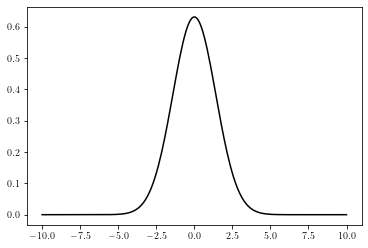

In [16]:
plt.plot(x,f_,'k-')
plt.show()

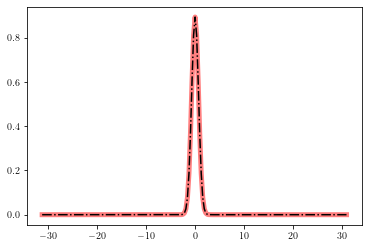

In [18]:
plt.plot(k,np.abs(f_t),'r-',lw=5,alpha=0.5)
plt.plot(k,F(k,sig=1),'k-.')
plt.show()

# Test: Gaussian wave packet propagation

In [106]:
def Psi2_gwp(x,t,m=1,sig=1,k=0,x0=0):
    return 1/np.sqrt(2*np.pi*sig**2)*2*sig**2*m/np.sqrt(4*sig**4*m**2+t**2)*np.exp(-2*m**2*sig**2*(x-x0-k*t/m)**2/(4*sig**4*m**2+t**2))

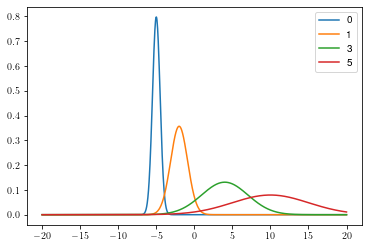

In [113]:
x = np.linspace(-20,20,1000)
for _ in [0,1,3,5]:
    plt.plot(x,Psi2_gwp(x,_,x0=-5,sig=0.5,k=3),label=_)
    
plt.legend()
plt.show()

In [91]:
x,y,k,x0 = sp.symbols(r'x y k x_0',real=True)
t,m,sig      = sp.symbols(r't m \sigma',real=True,positive=True)

expr  = -(-m*(x-y)**2/(2*sp.I*t) - (y - x0)**2/(4*sig**2) + sp.I*k*y)
a,b,c = sp.Poly(expr.series(y),y).coeffs()

In [92]:
display(a)
display(b)
display(c)

(-2*I*\sigma**2*m + t)/(4*\sigma**2*t)

(-2*I*\sigma**2*k*t + 2*I*\sigma**2*m*x - t*x_0)/(2*\sigma**2*t)

(-2*I*\sigma**2*m*x**2 + t*x_0**2)/(4*\sigma**2*t)

In [105]:
psi = 1/sp.sqrt(2*sp.pi*sig**2)*m/(2*sp.pi*t)*sp.pi/sp.Abs(a)*sp.exp(2*sp.re((b**2/4/a-c).expand()).factor())
sp.integrate(psi,(x,-sp.oo,sp.oo))


1

-2*\sigma**2*(-k*t + m*x - m*x_0)**2/(4*\sigma**4*m**2 + t**2)

In [81]:
psi = 1/sp.sqrt(sp.sqrt((2*sp.pi*sig**2)))*sp.exp(-(x-x0)**2/(4*sig**2))*sp.exp(sp.I*k*x)
sp.integrate(psi.conjugate()*-sp.I*psi.diff(x),(x,-sp.oo,sp.oo))

-I*k*m*sqrt(-I/t)*sin(atan2(-1/t, 0)/2)*conjugate(1/sqrt(Abs(t)))/(2*pi) + k*m*sqrt(-I/t)*cos(atan2(-1/t, 0)/2)*conjugate(1/sqrt(Abs(t)))/(2*pi)

In [85]:
psi = 1/sp.sqrt(sp.sqrt((2*sp.pi*sig**2)))*sp.sqrt(sp.pi/a)*sp.sqrt(m/(2*sp.pi*sp.I*t))*sp.exp(b**2/4/a-c)
(sp.Abs(psi)**2).simplify()

sqrt(2)*\sigma*m*sqrt(-I/t)*exp(-I*atan2(-1/t, 0)/2 - (t*x_0**2 + re((2*I*\sigma**2*k*t - 2*I*\sigma**2*m*x + t*x_0)**2/(2*I*\sigma**2*m - t)))/(2*\sigma**2*t))*Abs(-sqrt(t)/(2*I*\sigma**2*m - t))/sqrt(pi)

In [87]:
rho = 1/sp.sqrt((2*sp.pi*sig**2))*2*m*sig**2/(2*m*sig**2+t**2)*sp.exp(-2*m**2*sig**2*(x-(x0+k*t/m))**2/(4*sig**4*m**2+t**2))
sp.integrate(rho,(x,-sp.oo,sp.oo))


sqrt(4*\sigma**4*m**2 + t**2)/(2*\sigma**2*m + t**2)